<a href="https://colab.research.google.com/github/arsyiadlani/Time_Series_Analysis/blob/main/us_house_energy_consumption_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##DATA RETRIEVING

In [ ]:
from google.colab import drive

drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd

df = pd.read_csv("/content/drive/My Drive/HomeC.csv")
df

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0,27) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,time,use [kW],gen [kW],House overall [kW],Dishwasher [kW],Furnace 1 [kW],Furnace 2 [kW],Home office [kW],Fridge [kW],Wine cellar [kW],Garage door [kW],Kitchen 12 [kW],Kitchen 14 [kW],Kitchen 38 [kW],Barn [kW],Well [kW],Microwave [kW],Living room [kW],Solar [kW],temperature,icon,humidity,visibility,summary,apparentTemperature,pressure,windSpeed,cloudCover,windBearing,precipIntensity,dewPoint,precipProbability
0,1451624400,0.932833,0.003483,0.932833,0.000033,0.020700,0.061917,0.442633,0.124150,0.006983,0.013083,0.000417,0.000150,0.000000,0.031350,0.001017,0.004067,0.001517,0.003483,36.14,clear-night,0.62,10.00,Clear,29.26,1016.91,9.18,cloudCover,282.0,0.0000,24.40,0.00
1,1451624401,0.934333,0.003467,0.934333,0.000000,0.020717,0.063817,0.444067,0.124000,0.006983,0.013117,0.000417,0.000150,0.000000,0.031500,0.001017,0.004067,0.001650,0.003467,36.14,clear-night,0.62,10.00,Clear,29.26,1016.91,9.18,cloudCover,282.0,0.0000,24.40,0.00
2,1451624402,0.931817,0.003467,0.931817,0.000017,0.020700,0.062317,0.446067,0.123533,0.006983,0.013083,0.000433,0.000167,0.000017,0.031517,0.001000,0.004067,0.001650,0.003467,36.14,clear-night,0.62,10.00,Clear,29.26,1016.91,9.18,cloudCover,282.0,0.0000,24.40,0.00
3,1451624403,1.022050,0.003483,1.022050,0.000017,0.106900,0.068517,0.446583,0.123133,0.006983,0.013000,0.000433,0.000217,0.000000,0.031500,0.001017,0.004067,0.001617,0.003483,36.14,clear-night,0.62,10.00,Clear,29.26,1016.91,9.18,cloudCover,282.0,0.0000,24.40,0.00
4,1451624404,1.139400,0.003467,1.139400,0.000133,0.236933,0.063983,0.446533,0.122850,0.006850,0.012783,0.000450,0.000333,0.000000,0.031500,0.001017,0.004067,0.001583,0.003467,36.14,clear-night,0.62,10.00,Clear,29.26,1016.91,9.18,cloudCover,282.0,0.0000,24.40,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
503906,1452128306,1.599333,0.003233,1.599333,0.000050,0.104017,0.625033,0.041750,0.005233,0.008433,0.013433,0.000467,0.000100,0.000033,0.032200,0.000950,0.003800,0.000933,0.003233,35.12,rain,0.86,8.74,Light Rain,29.45,1011.49,6.72,0.31,186.0,0.0101,31.27,0.51
503907,1452128307,1.924267,0.003217,1.924267,0.000033,0.422383,0.637733,0.042033,0.004983,0.008467,0.012933,0.000533,0.000067,0.000000,0.032283,0.001000,0.003750,0.001000,0.003217,35.12,rain,0.86,8.74,Light Rain,29.45,1011.49,6.72,0.31,186.0,0.0101,31.27,0.51
503908,1452128308,1.978200,0.003217,1.978200,0.000050,0.495667,0.620367,0.042100,0.005333,0.008233,0.012817,0.000517,0.000117,0.000017,0.032183,0.000950,0.003767,0.000950,0.003217,35.12,rain,0.86,8.74,Light Rain,29.45,1011.49,6.72,0.31,186.0,0.0101,31.27,0.51
503909,1452128309,1.990950,0.003233,1.990950,0.000050,0.494700,0.634133,0.042100,0.004917,0.008133,0.012833,0.000517,0.000117,0.000017,0.032167,0.000950,0.003767,0.000950,0.003233,35.12,rain,0.86,8.74,Light Rain,29.45,1011.49,6.72,0.31,186.0,0.0101,31.27,0.51


In [ ]:
# Selecting particular column from the dataset
df = df[["time", "House overall [kW]"]]
df

,time,House overall [kW]
0,1451624400,0.932833
1,1451624401,0.934333
2,1451624402,0.931817
3,1451624403,1.022050
4,1451624404,1.139400
...,...,...
503906,1452128306,1.599333
503907,1452128307,1.924267
503908,1452128308,1.978200
503909,1452128309,1.990950


##DATA PREPROCESSING

In [ ]:
# Checking for null values in the dataset
df.isnull().sum()

time                  0
House overall [kW]    1
dtype: int64

In [ ]:
# Handling null values in the dataset
df = df[(df["time"].notna()) & (df['House overall [kW]'].notna())]  # Selecting the non-null value only
print(df.isnull().sum())
print(df.shape)

time                  0
House overall [kW]    0
dtype: int64
(503910, 2)


In [ ]:
# Preparing the dataset
df["time"] = pd.to_datetime(df["time"], unit="s")  # Converting timestamp into datatime type
df = df.rename({"House overall [kW]": "energy_consumption"})
df

,time,energy_consumption
0,2016-01-01 05:00:00,0.932833
1,2016-01-01 05:00:01,0.934333
2,2016-01-01 05:00:02,0.931817
3,2016-01-01 05:00:03,1.022050
4,2016-01-01 05:00:04,1.139400
...,...,...
503905,2016-01-07 00:58:25,1.601233
503906,2016-01-07 00:58:26,1.599333
503907,2016-01-07 00:58:27,1.924267
503908,2016-01-07 00:58:28,1.978200


In [ ]:
datetime = df["time"].values
energy_consumption = df["energy_consumption"].values

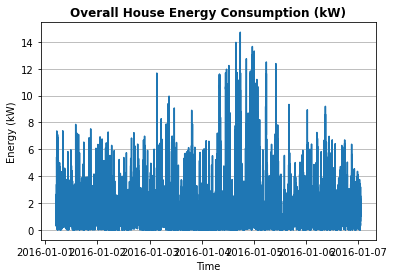

In [ ]:
# Visualizing the dataset
import matplotlib.pyplot as plt

plt.plot(datetime, energy_consumption)
plt.title("Overall House Energy Consumption (kW)", weight="bold")
plt.xlabel("Time")
plt.ylabel("Energy (kW)")
plt.grid(b=1, axis="y")

plt.show()

In [ ]:
from sklearn.model_selection import train_test_split

# Splitting the dataset
x_train, x_test, y_train, y_test = train_test_split(datetime, energy_consumption, test_size=0.2)

# Checking dataset splitting result
print(f"Training time data: {x_train.size} data")
print(f"Training energy data: {y_train.size} data")
print(f"Val time data: {x_test.size} data")
print(f"Val energy data: {y_test.size} data")
print(f"Total data: {x_train.size + x_test.size} data")

Training time data: 403128 data
Training energy data: 403128 data
Val time data: 100782 data
Val energy data: 100782 data
Total data: 503910 data


In [ ]:
import tensorflow as tf

# Windowing the dataset
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  series = tf.expand_dims(series, axis=-1)
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
  ds = ds.flat_map(lambda w: w.batch(window_size + 1))
  ds = ds.shuffle(shuffle_buffer)
  ds = ds.map(lambda w: (w[:-1], w[-1:]))
  return ds.batch(batch_size).prefetch(1)

train_dataset = windowed_dataset(y_train, window_size=120, batch_size=256, shuffle_buffer=403128)
val_dataset = windowed_dataset(y_test, window_size=120, batch_size=128, shuffle_buffer=100782)

##MODEL TUNING AND STRUCTURING

In [ ]:
# Calculating the dataset scale
data_scale = df["energy_consumption"].max() - df["energy_consumption"].min()
print(f"Skala data = {data_scale}")

# Calculating maximum error allowed for mae
mae_range = 0.1 * data_scale
print(f"Batas maksimal error mae = {mae_range}")

Skala data = 14.71456667
Batas maksimal error mae = 1.471456667


In [ ]:
# Implementing callback
class MyCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if ((logs.get("mae") < 0.52) and (logs.get("val_mae") < 0.52)):
      print("\nModel error has reached a value lower than 3.5% of the data scale!")
      self.model.stop_training = True

callbacks = MyCallback()

# Building and structuring the neural model
model = tf.keras.Sequential([
        tf.keras.layers.LSTM(64, return_sequences=True),
        tf.keras.layers.LSTM(64),
        tf.keras.layers.Dense(30, activation="relu"),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(10, activation="relu"),
        tf.keras.layers.Dense(1)
])

# Setting up the model optimizer and loss function
optimizer = tf.keras.optimizers.SGD(learning_rate=0.000001, momentum=0.99)
loss = tf.keras.losses.Huber()

model.compile(loss=loss, optimizer=optimizer, metrics=["mae"])

# Training the neural model
history = model.fit(train_dataset, validation_data=(val_dataset,), epochs=10, 
                    callbacks=[callbacks], verbose=2)

Epoch 1/10
1575/1575 - 48s - loss: 0.4675 - mae: 0.8360 - val_loss: 0.4281 - val_mae: 0.7718
Epoch 2/10
1575/1575 - 47s - loss: 0.4083 - mae: 0.7363 - val_loss: 0.3866 - val_mae: 0.6995
Epoch 3/10
1575/1575 - 49s - loss: 0.3627 - mae: 0.6535 - val_loss: 0.3342 - val_mae: 0.6011
Epoch 4/10
1575/1575 - 48s - loss: 0.3168 - mae: 0.5694 - val_loss: 0.2976 - val_mae: 0.5398
Epoch 5/10
1575/1575 - 48s - loss: 0.2888 - mae: 0.5280 - val_loss: 0.2762 - val_mae: 0.5156
Epoch 6/10

Model error has reached a value lower than 3.5% of the data scale!
1575/1575 - 48s - loss: 0.2725 - mae: 0.5150 - val_loss: 0.2641 - val_mae: 0.5120


##MODEL LOSS AND ERROR VISUALIZATION

###LOSS VISUALIZATION

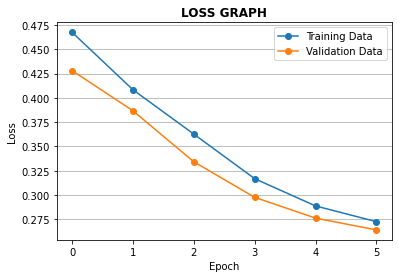

In [ ]:
# Plot training and validation loss during learning process
import matplotlib.pyplot as plt

plt.plot(history.history["loss"], marker="o", label="Training Data")
plt.plot(history.history["val_loss"], marker="o", label="Validation Data")
plt.title("LOSS GRAPH", weight="bold")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(b=1, axis="y")
plt.legend()

plt.show()

###ERROR VISUALIZATION

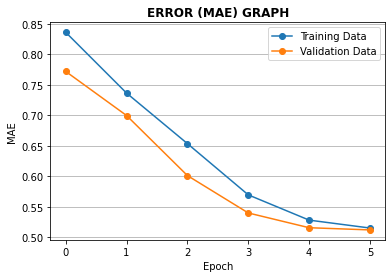

In [ ]:
# Plot training and validation error during learning process
import matplotlib.pyplot as plt

plt.plot(history.history["mae"], marker="o", label="Training Data")
plt.plot(history.history["val_mae"], marker="o", label="Validation Data")
plt.title("ERROR (MAE) GRAPH", weight="bold")
plt.xlabel("Epoch")
plt.ylabel("MAE")
plt.grid(b=1, axis="y")
plt.legend()

plt.show()

##REFERENCE

###Dataset source: https://www.kaggle.com/taranvee/smart-home-dataset-with-weather-information